# Electrodynamics

* **Author:**

* **Date:**

* **Time spent on this assignment:**

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.patches as patches
import matplotlib.colors as mcl
import warnings
from functools import partial
import matplotlib.animation as animation
from IPython.display import HTML
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','jax','jnp','jit','grad','HTML','animation','mcl','scipy','patches','mcl','warnings','config','partial','datetime','c','epsilon0']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    plt.rcParams.update({"font.size": 14})
    return
resetMe()
import datetime;datetime.datetime.now()
warnings.filterwarnings("ignore", message="RMS of", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="some failed to converge", category=RuntimeWarning)
epsilon0=8.854187817e-12
c=3e8
q=1.6e-19

In [4]:

def GetPositions(L,gridPoints,returnMesh=False):
    xs=np.linspace(-L,L,gridPoints)
    ys=np.linspace(-L,L,gridPoints)
    X,Y=np.meshgrid(xs,ys)
    Z=np.zeros((gridPoints,gridPoints))
    positions=np.vstack((X.flatten(),Y.flatten(),Z.flatten())).T
    if returnMesh:
        return positions,X,Y
    else:
        return positions

def PlotScalarField(field,L):
    assert(field.ndim==1)
    length = len(field)
    side_length = int(np.sqrt(length))
    field_2d=field.reshape(side_length,side_length)
    plt.imshow(field_2d,extent=[-L,L,-L,L],cmap='hsv')
    plt.colorbar()
    return


def PlotField(field,L,density=2.0):
    assert(field.ndim==2)
    length = field.shape[0]
    side_length = int(np.sqrt(length))
    #print("side legnth is ",side_length)
    _,X,Y=GetPositions(L,side_length,True)
    field_2d=field.reshape(side_length,side_length,3)
    E_x=field_2d[:,:,0]
    E_y=field_2d[:,:,1]
    E_z=field_2d[:,:,2]
    E_strength=np.log(E_x**2+E_y**2+E_z**2)
    fig, ax = plt.subplots()
    ax.streamplot(X,Y,E_x, E_y, color=E_strength, linewidth=1.0, cmap='hsv', density = density, arrowstyle='->', arrowsize=1)



def PlotSliceY(field,L,x=0,marker=None,linestyle='-'):
    assert(field.ndim==1)
    length = len(field)
    side_length = int(np.sqrt(length))
    field_2d=field.reshape(side_length,side_length)
    loc=int((x/L+0.5)*side_length)
    length = len(field_2d[loc,:])
    x=np.linspace(-L,L,length)
    plt.plot(x,field_2d[loc,:],marker=marker,linestyle=linestyle)

def PlotSliceX(field,L,x=0,marker=None,linestyle='-'):
    assert(field.ndim==1)
    length = len(field)
    side_length = int(np.sqrt(length))
    field_2d=field.reshape(side_length,side_length)
    loc=int((x/L+0.5)*side_length)
    length = len(field_2d[loc,:])
    x=np.linspace(-L,L,length)
    plt.plot(x,field_2d[:,loc],marker=marker,linestyle=linestyle)




class OptMeClass:
    def __init__(self,cost,numPositions,r,initial_guess=None):
        self.cost= partial(cost, r)
        if initial_guess is None:
            self.guess=-1e-8*np.ones(numPositions)
        else:
            self.guess=initial_guess

    def Optimize(self,t0,positions,maxiter=1000):
        ts = np.zeros((positions.shape[0]))+t0


        tr=scipy.optimize.newton(self.cost, self.guess,
                               args=(t0, positions), tol=1e-23,maxiter=50)
        self.guess=np.abs(tr)*-1
        tr=scipy.optimize.newton(self.cost, self.guess,
                        args=(t0, positions), tol=1e-23,maxiter=50)
        self.guess=np.abs(tr)*-1
        tr=scipy.optimize.newton(self.cost, self.guess,
                               args=(t0, positions), tol=1e-23,maxiter=maxiter)
        self.guess=np.abs(tr)*-1
        print("Number of positive values",np.sum(tr>0))
        print("Cost ",np.average(self.cost(tr,t0,positions)))
        self.tr=np.copy(tr)
        return tr


## Exercise 1.  Analytical Solutions for a Point Charge at Constant Velocity

In this exercise, we are going to write down the analytic solutions for a moving point charge.  These are easy to look up and this will give us some experience plotting a variety of scalar and vector fields.  In the next exercise, we will develop some code which produces the same results but done in a way that allows us to generalize to any (set of) moving point charges.  This more general code will then allow us to generate the field for some interesting examples such as a charge following an orbit; and an antannea.

### a.  The Scalar Potential

The scalar potential for a point charge (source) who position is $x(t)=v t$ at time $t$ is

$$
\phi(r,t) = \frac{q}{4 \pi \epsilon_0 \sqrt{1 - \left(\frac{v}{c}\right)^2}} \cdot \frac{1}{\sqrt{\left(\frac{(x - vt_s)^2}{1 - \left(\frac{v}{c}\right)^2}\right) + y^2 + z^2}}
$$

and

$$
A(r,t)=\frac{1}{c} \frac{q}{4\pi\epsilon_0\sqrt{1-\left(\frac{v}{c}\right)^2}}\cdot\frac{\frac{v}{c}}{\left(\frac{(x-vt_s)^2}{1-\left(\frac{v}{c}\right)^2}+y^2+z^2\right)^{1/2}}
$$

where $r=(x,y,z)$ is the position we are evaluating the potentials at.

Throughout these exercises, we will want to evaluate our potentials and fields at many points - let's say $k$ points. We will be calling all our relevant functions with a variable `position` which will be a $k \times 3$ numpy array which will store the three-dimensional positions.  

Write a function `def ExactPotential(positions,t)` which takes positions and returns their field values $\phi$ (which should be a $k$ length numpy array) and $A$ (which should be a $k \times 3$ length numpy array). Use a velocity of $0.9c$.  For this assignment, we will always be working in SI units. You may find it useful to use `np.vstack([A_x,A_y,A_z]) on three $k$ length arrays to get your $k \times 3$ array.

You may find the following functions useful:
* `x=positions[:,0]` will get your x positions
* `np.sqrt(...)` will take a square root
* to get $x^{3/2}$ you can take `x**(3/2)`
* you don't need to loop over your arrays. You can just multiply them by each other and scalars.

The positions that we will send this function will typically be in some two-dimensional window - i.e.

$$
\begin{aligned}
-L &< x < L \\
-L &< y < L
\end{aligned}
$$

Here we will let $L=0.4$ with a resolution of $1000 \times 1000$

We've given you a function `positions=GetPositions(L,gridPoints)` which takes $L$ and the number of gridpoints in one direction, and then returns
the list of `positions` that will be useful for plotting vector fields.  

Once you have your `ExactPotential` function we will need to plot some things.  To help out with this, we've given you some additional useful functions above:
* `PlotScalarField(field,L)` which takes the output of a scalar field (i.e. a $k$ length numpy array) and plot it in the $2L \times 2L$ window.
* `PlotField(field,L,density=2.0)` which takes the output of a vector field (i.e. a $k \times 3$ numpy array) and plots field lines in the $2L \times 2L$ window.
* `PlotSliceX(field,L,x=0,marker=None,linestyle='-')` which takes a scalar field and L and $x$ and plots the one-dimensional slice through the field at that value of $x$.
* There is an analogous `PlotSliceY`
After each call to these functions, you need to call `plt.show()`

Using these functions, plot the logarithm of the scalar potential as well as the vector potential $A$

Also plot a slice through both $\phi$ and $A_x$ choosing $y=-0.08$ and $x=-0.1$ respectively.


These curves will be the results you compare against later.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

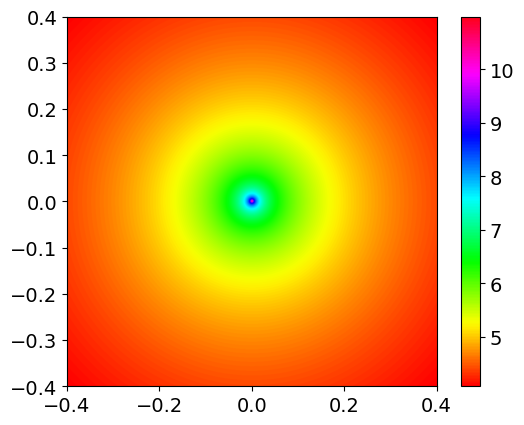

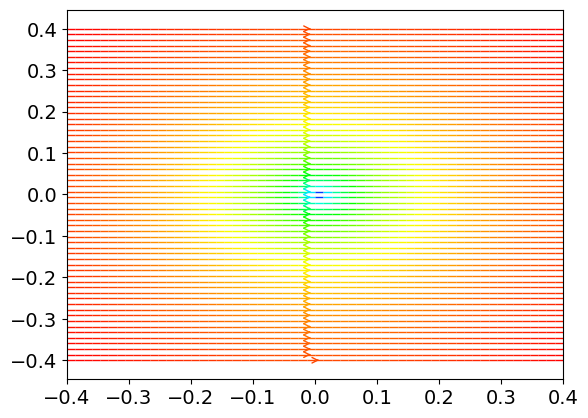

In [14]:
def GetExactPotential(positions,t,v):
    x=positions[:,0]
    y=positions[:,1]
    z=positions[:,2]
    gamma = 1/np.sqrt(1-(v/c)**2)
    ts = np.sqrt((x-v*t)**2+y**2+z**2)
    correct_phi= 1/(4*np.pi*epsilon0)*gamma*1/np.sqrt(((x-v*ts)**2/(1-(v/c)**2))+y**2+z**2)
    Ax_correct =q*v*c**(-2)*correct_phi
    Ay_correct = np.zeros_like(Ax_correct)
    Az_correct = np.zeros_like(Ax_correct)
    correct_A=np.vstack((Ax_correct,Ay_correct,Az_correct)).T/c
    return correct_phi,correct_A


L=0.4
numPoints=1000
positions =GetPositions(L,numPoints)
phi,A=GetExactPotential(positions,0,0.9*c)
PlotScalarField(np.log(phi),L); plt.show()
PlotField(A,L,density=2.0); plt.show()




<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

### b. The Electric Field

The electric field of a point charge moving at constant velocity $x=vt$ is

$$
E_x = \frac{q}{4 \pi \epsilon_0 \sqrt{1 - (v/c)^2}} \frac{x - vt}{\left(\frac{(x - vt)^2}{1 - (v/c)^2} + y^2 + z^2\right)^{3/2}}
$$

$$
E_y = \frac{q}{4 \pi \epsilon_0 \sqrt{1 - (v/c)^2}} \frac{y}{\left(\frac{(x - vt)^2}{1 - (v/c)^2} + y^2 + z^2\right)^{3/2}}
$$

$$
E_z = \frac{q}{4 \pi \epsilon_0 \sqrt{1 - (v/c)^2}} \frac{z}{\left(\frac{(x - vt)^2}{1 - (v/c)^2} + y^2 + z^2\right)^{3/2}}
$$

Implement a function which computes this for the same positions as the scalar field and plot the electric field using `PlotField`.



<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
def GetExactFields(positions,t):
    v=0.9*c
    #x=positions[:,0]
    ###
    return correct_E


#E=GetExactFields(positions,0)



<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

## Exercise 2.   A point charges at a constant velocity (take 2)

We are again going to compute the field of a particle going at constant velocity but using a more general (albeit harder) approach.

Our starting point in this exercise will be the Liénard–Wiechert potential  - i.e. that the scalar and vector potential fields at position $r$ and time $t$ are

$$\phi(r,t) = \frac{q}{4\pi\epsilon_0}\left(\frac{1}{(1- n_s\cdot \beta_s) |r-r_s|} \right)_{t_r}$$

$$A(r,t) = \frac{\beta_s}{c}\phi(r,t)$$

where $\beta_s(t)= v_s(t)/c$, $r_s$ is the source location of the charge, and $n_s =\frac{r-r_s}{|r-r_s|}$. The notation $(...)_{t_r}$ indicates anything inside the parenthesis has to be evaluated at **retarded times**.  Essentially what this is telling us is that we need to (almost) use the coulomb's law we know and love but have to assume that the field moves at the speed of light to get to you!

We will devlop our code for the simplest case - a point charge moving at a constant velocity - before we turn our attention in the next exercises to more interesting cases.

### a. The Path

Our point charge plots out some path in space $r(t)$ at some velocity $v(t)$.  We will need to implement these two functions

*  `def r(tr)` which takes the time $t_r$ and returns the position of the electron as a three-element numpy array (i.e `[x,y,z]`).
* `def velocity(tr)` which takes a time $t_r$ and returns the velocity of the electron as a three-element numpy array (i.e `[x,y,z]`)

for the moving point charge.

In this problem, we will  work with a particle that is moving at a constant velocity and at the origin at $t=0$ - i.e.

$$x(t) = v t; y(t)=z(t)=0$$
As in exercese 1, let the magnitude of the velocity be $|v|=0.9c$

To make sure you have this correct make three plots:
* $x(t)$ vs $t$ and $y(t)$ vs $t$ (on the same plot)
* $v_x(t)$ vs $t$ and $v_y(t)$ vs $t$ (on the same plot)
* $y$ vs. $x$

Let $-10^{-7}<t<10^{-7}$
You can use `ts=np.linspace(-1e-8,1e-8,1000)` to get an array of the times.


As an example of something you need, you can use `r(ts)[:, 0]` to get the x-position of your path over the time `ts`


To plot in general, you can do something like:
```
plt.plot(t,x,label="x")
plt.plot(t,y,label="y")
plt.xlabel("x label")
plt.legend()
plt.show()
```


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
def r(tr):

    return #

def v(tr):

    return #

ts=np.linspace(-1e-8,1e-8,1000)
#plt.plot(...)

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

### b.  Retarded time


The potential at position $(x,y)$ comes from a moving point charge depends not on where the point charge is currently but depends on where the point charge was in the past - in particular, where the point charge was so that if the potential moved at the speed of light it could have reached position $(x,y)$.


To accomplish this, we need to figure out, given a field position and a target time $t_0$, at what (retarded) time (and hence from where) the point charge affect the field.   This is somewhat non-trivial because (letting $f$ be the field position), we need to know that the time for the particle to get to $t_0$ (i.e. $t_0-t_r$) and the time for light to get to the field point $f$ (i.e. $|r(t_r)-f|/c$) has to be equal,

$$\frac{|r(t_r) - f|}{c} = (t_0-t_r)$$

where $t_0$ is the current time and $t_r$ is the target retarded time.  In other words, the field moving at the speed of light had time to get from the source to the field point.



Notice that this equation depends on $t_r$ both on the l.h.s. and the r.h.s.  While for a particle path $r(t_r)$ there might be an analytic equation which solves for $t_r$ that won't be the case in general.  Instead, what we will do is search or optimize for a $t_r$ that satisfies this equation.  

To do this what we will do is set up a cost function `Cost(r,tr,t0,p)` which takes the function `r`, a k-length 1-d numpy array of retarded times, a scalar $t_0$ which is the instantaneous time of the source charge, and a $k  \times 3$ numpy array of positions.  It should return a single scalar which is zero if the retarded times all are correct and is otherwise positive quantifying how far away they are.  In other words, the cost function tells you if you are satisifying the equation above.

Then all we need to do is minimize the cost function.  If we find a $t_r$ for every point that makes it zero, then we know that we have found the time at which the source particle is generating the field.  

You will do this optimization using the Newton-Raphson.  We've wrapped this in a `OptMeClass` for you, but essentially we are just calling Newton-Raphson.  The class

```
numPositions=positions.shape[0]
opt=OptMeClass(cost,numPositions,r)
```

is initialized by giving it the cost function, the number of positions and the position function `r`.  Then you can call it by doing

```
tr=opt.Optimize(t0,positions)
```

where `t0` is the target time, `positions` is your array of positions.   It should return an array of retarded times.  It will print out the value of the cost function and the number of times that are positive (which if you're asking it for $t_0=0$ any positive times are bad because the retarded time has to be in the past)

Other then calling the Newton-Raphsody, it's playing with the initial guesses a bit to try to help it find a reasonable answer.  I've tuned things to have "good" initial guesses for $t_0=0$.  If you are looking at other times (which you won't do in this assignment), you might need to tune things differently in the class.

Run this and make sure that your cost function is relatively tiny (~1e-16) and that you have no positive values of the time.   

Then plot the slice of time $t_r$ at $y=0$ You can do this using `PlotSliceY`.   It should look something like this:

**Graph HERE**

Here are some interesting things your should notice about the retarded time:
* Field positions that are at positive $x$ require a retarded time that is more negative in time then other positions. That's because these positions are further away and it therefore takes longer for light to get there.
* Field positions that are at the origin require no time. since that's where the source point is.
* For both field positions with $x<0$ and $x>0$ the retarded time is linear as a function of $x$ with separate slopes.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
def cost(r,tr,t0,p):
    # ....
    return ans

#numPoints=positions.shape[0]
#opt=OptMeClass(cost,numPoints,r)
#tr=opt.Optimize(0,positions)

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

Now that you have the retarded time, we'd also like to look at which field positions correspond to which source locations.    

The following code plots 20 fields points (shown as x's) and the respective source particle (shown as a solid dots) that they are connected to.  The yellow patch is the window that we are visualizing the field in.  Graph this.

```
plt.figure(figsize=(10,10))
numPoints=np.sqrt(positions.shape[0]).astype(int)
xCheck=np.random.randint(0,1000,size=20)
yCheck=np.random.randint(0,1000,size=20)
theColors=list(mcl.BASE_COLORS.keys())+list(mcl.TABLEAU_COLORS.keys())
theColors.remove('w')
for i in range(0,3):
    theColors=theColors+theColors


plt.grid()
rect = patches.Rectangle((-L, -L), 2*L, 2*L, linewidth=1, edgecolor='r', facecolor='yellow',alpha=0.2)
plt.gca().add_patch(rect)
for i in range(0,len(xCheck)):
    xi=xCheck[i]
    yi=yCheck[i]
    fieldPosition=positions[yi*numPoints+xi]
    sourcePosition=r(tr[yi*numPoints+xi])
    dist=np.linalg.norm(fieldPosition-sourcePosition)   
    plt.plot([fieldPosition[0],sourcePosition[0]],[fieldPosition[1],sourcePosition[1]],'-',linewidth=2*dist,color=theColors[i],alpha=0.8)
    plt.plot([fieldPosition[0]],[fieldPosition[1]],marker='x',color=theColors[i],markersize=10)
    plt.plot([sourcePosition[0]],[sourcePosition[1]],marker='o',color=theColors[i],markersize=10)

plt.plot([0],[0],marker='o',color='k',markersize=10,fillstyle='none')
plt.show()
```

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

### c. The scalar and vector potentials

Now let us use the Liénard–Wiechert potential equations at the beginning of this exercise along with the retarded time we've computed to evaluate the scalar and vector potentials. Remember that $r_s$ and $v_s$ are the locations of the source at the retarded times and $r$ is the field position.

Write a function `GetPotential(positions,t0,opt,r,v)` which takes the positions, the scalar $t0=0$, the optimization class, position function, and velocity function.  Make sure you are optimizing your retarded time locations inside this function!

Check that you get the correct answer by doing the same slice that you did in exercise 1.

*Hints*: To get the norm $|r-r_s|$ you can do
```
r_minus_rs=r(tr)-positions
norm=np.linalg.norm(r_minus_rs,axis=1)
```

Once you have phi, it will be easiest to get $A$ by doing
```
A=betas/c*phi[:,np.newaxis]
```

where `betas` is the appropriate array of velocities (scaled by $c$).  The use of `np.newaxis` makes the shapes of the arrays all work out.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (end)"></img><br></div>

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

### d. Electric fields

Now we want to compute the electric field.

The electric field is

$$
E=-\nabla \phi - \frac{\partial A}{\partial t}
$$

To compute this, we need to take the derivative of the scalar field $\phi$ with respect to the x,y, and z terms in the positions and the derivative of the vector potential with respect to time.

We will take these using finite differences.    For example,

$$
\frac{\partial \phi}{\partial x}=\frac{\phi(x+\delta,y,z)-\phi(x-\delta,y,z)}{2\delta}
$$

Using our `GetPotential` function we can compute both the terms in this fraction and thereby evaluate the derivative.  You can do this for all six derivatives you need.

Use $\delta x=\delta y = \delta z = 10^{-13}$ and $\delta t=10^{-21}$.

Write a `GetFields(positions,t0,cost,r,v)` function which takes the positions, the target time $t_0$, the cost function, position function, and velocity function and returns the fields.   

The first thing you will need to do in your function is define an optimization class.

Plot the electric field.

Verify that you are getting the correct results by comparing with the exact answer.

There are a couple interesting things you might notice:
* The contraction of the field lines is coming from special relativity (despite us not putting in any special relativity)
* Amazingly, despite the field values all coming form the source at different points, the field lines emanate from the current source location.  This is really pretty crazy/amazing.

When you are getting the derivatives, it helps to copy the positions first and then add some delta onto them like
```
    positions_deriv=np.copy(positions)
    positions_deriv[:,0]+=delta
```
to get one term necessary for the x-derivative

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
### answer here

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

## Exercise 2. Charged Particle on a Ring

In this exercise, we can use essentially all the same code while calculating the field of a charged particle on a ring.

### a. Charged particle on a ring

In the previous exercise we considered a particle moving at a constant velocity.  Here let's consider a particle moving on a ring of radius $r=0.1$ at a velocity whose magnitude is 0.9c.    Write your path functions `r(t)` and `v(t)`.   Again plot
* $x(t)$ vs $t$ and $y(t)$ vs $t$ (on the same plot)
* $v_x(t)$ vs $t$ and $v_y(t)$ vs $t$ (on the same plot)
* $y$ vs. $x$

Let $-10^{-8}<t<10^{-8}$

Using the same window and resolution
```
L=0.4
numPoints=1000
positions=GetPositions(L,numPoints)
```

find the retarded time for these positions and (copying down the code from earlier) plot the connection between field lines and source particle locations for 20 random field locations.


<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
### answer here

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

### b. Generate the fields

Once you have the path you should be able to call your `GetFields` function to get the field lines again.  Plot these field lines using `PlotField` but before you call `plt.show()` it's worth adding a circle of radius 0.1 so you can see where the particle is circling
```
circle = patches.Circle((0, 0), 0.1, edgecolor='r', facecolor='none')
plt.gca().add_patch(circle)
```

In addition, it's instructive (and cool-looking) to plot a scalar field separately of the field strength `E_strength=np.log(E[:,0]**2+E[:,1]**2+E[:,2]**2)`.  Go ahead and do this.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
### answer here

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (edn)"></img><br></div>

## Exercise 3.  Monopole Antannea

### a. A one-dimensional oscillating charge

Instead of a particle orbitting a ring of charge, let's instead do a charge oscillating back and forth in the x-direction as $x(t) = 0.1 \cos (t v)$ where $v=9c$  

Again plot
* $x(t)$ vs $t$ and $y(t)$ vs $t$ (on the same plot)
* $v_x(t)$ vs $t$ and $v_y(t)$ vs $t$ (on the same plot)
* $y$ vs. $x$

Let $-10^{-8}<t<10^{-8}$

Make sure the velocity is correct.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (edn)"></img><br></div>

In [ ]:
### answer here

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (edn)"></img><br></div>

### b. The field

Now let's generate the field.  Here it will look better if we use a window with $L=2$ - i.e.
```
L=2
numPoints=1000
positions,X,Y=GetPositions(L,numPoints)
```

Go ahead and generate the field plotting it as well as seprately the scalar field of the logarithm of the field strength.  I get nicer results for my fields if I use a `density=4.0` in the call to `GetFields`

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
### answer here

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (edn)"></img><br></div>

## Exercise 4.  An oscillating dipole

### a.  Making the oscillating dipole

Finally, we'd like to do an oscillating dipole. An oscillating dipole has two charges of different signs which pass back and forth by each other - i.e. the positive charge is doing $x(t) = 0.1 \cos (t v)$  while the negative charge is doing $x(t) = -0.1 \cos (t v)$.

Define two functions `rA` and `rB` and their respective `vA` and `vB` and plot the relevant quantities to make sure that they look right.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>

### b. The fields

For this problem, all you need to do is call your `GetFields` function twice - once with `rA` and `vA` and once with `rB` and `vB`.

These two fields then need to be added together (actually in practice you will subtract them because one of those fields is with an opposite charge).

This combined electric field can then be plotted and will give you the electric field lines for a dipole.

<div><img src="https://clark.physics.illinois.edu/246img/AnsStart.svg" width=200 align=left alt="Answer (start)"></img><br></div>

In [ ]:
### answer here

In [ ]:
### answer here

<div><img src="https://clark.physics.illinois.edu/246img/AnsEnd.svg" width=200 align=left alt="Answer (end)"></img><br></div>